In [1]:
# ===================================================================
# PROJETO DE ANÁLISE - GRUPO ZOOBENTOS (VERSÃO FINAL E COMPLETA)
# ===================================================================

# --- Bloco 1: Carga, Preparação e Definição de Saída ---
import pandas as pd
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from matplotlib.lines import Line2D
import skbio.diversity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

def salvar_check_excel(df, nome_arquivo_base, caminho_saida_grupo):
    """Salva um DataFrame em um arquivo Excel dentro de uma subpasta 'check'."""
    try:
        caminho_check = os.path.join(caminho_saida_grupo, 'check'); os.makedirs(caminho_check, exist_ok=True)
        nome_arquivo_excel = f"check_{nome_arquivo_base}.xlsx"; caminho_completo = os.path.join(caminho_check, nome_arquivo_excel)
        df.to_excel(caminho_completo, index=False); print(f"   -> Arquivo de verificação salvo em: '{caminho_completo}'")
    except Exception as e: print(f"   -> ERRO ao salvar arquivo de verificação '{nome_arquivo_base}': {e}")

plt.rcParams['font.family'] = 'Arial'; print("Projeto de Análise de Zoobentos iniciado."); print("Configurações visuais (Fonte Arial) aplicadas.")
subpasta_grupo = 'zoobentos'; caminho_saida_grupo = os.path.join('..', '03_relatorios', subpasta_grupo); os.makedirs(caminho_saida_grupo, exist_ok=True); print(f"Pasta de saída definida em: '{caminho_saida_grupo}'")
df_zoo_bruto = pd.DataFrame()
try:
    print("\n[1/2] Conectando ao banco de dados..."); load_dotenv(); db_user=os.getenv('DB_USER'); db_password=os.getenv('DB_PASSWORD'); db_host=os.getenv('DB_HOST'); db_name=os.getenv('DB_NAME')
    if not all([db_user, db_password, db_host, db_name]): raise ValueError("Credenciais do banco de dados não encontradas.")
    db_url = f"postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}"; engine = create_engine(db_url)
    query = text("""
        SELECT
            t1.nome_campanha, t1.nome_ponto, t1.nome_cientifico, t1.contagem,
            t1.tipo_amostragem, t1.bmwp_score,
            t2.filo, t2.classe, t2.ordem, t2.familia,
            t2.habito_alimentar, t2.valor_economico,
            t2.status_ameaca_nacional, t2.status_ameaca_global
        FROM public.biota_analise_consolidada AS t1
        LEFT JOIN public.especies AS t2 ON t1.nome_cientifico = t2.nome_cientifico
        WHERE t1.grupo_biologico = :grupo
    """)
    with engine.connect() as connection: df_zoo_bruto = pd.read_sql_query(query, connection, params={'grupo': 'Zoobentos'})
    print(f"   -> Conexão bem-sucedida. Total de registros: {len(df_zoo_bruto)}")
except Exception as e: print(f"   -> ERRO DURANTE A CARGA: {e}")

if not df_zoo_bruto.empty:
    print("\n[2/2] Limpando e padronizando dados..."); 
    df_zoo_limpo = df_zoo_bruto.copy()
    mapa_nomes = {'nome_campanha': 'campanha', 'nome_ponto': 'ponto_amostral', 'contagem': 'abundancia'}
    df_zoo_limpo.rename(columns=mapa_nomes, inplace=True)
    df_zoo_limpo['campanha'] = df_zoo_limpo['campanha'].str.replace('º', '', regex=False).str.replace('ª', '', regex=False)
    df_zoo_limpo.dropna(subset=['nome_cientifico'], inplace=True)

    print("\n--- Carga e Limpeza Concluídas. DataFrame 'df_zoo_limpo' pronto. ---")
    display(df_zoo_limpo.head())
else:
    print("\n--- AVISO: Nenhum dado de Zoobentos foi carregado. ---")

Projeto de Análise de Zoobentos iniciado.
Configurações visuais (Fonte Arial) aplicadas.
Pasta de saída definida em: '..\03_relatorios\zoobentos'

[1/2] Conectando ao banco de dados...
   -> Conexão bem-sucedida. Total de registros: 63

[2/2] Limpando e padronizando dados...

--- Carga e Limpeza Concluídas. DataFrame 'df_zoo_limpo' pronto. ---


,campanha,ponto_amostral,nome_cientifico,abundancia,tipo_amostragem,bmwp_score,filo,classe,ordem,familia,habito_alimentar,valor_economico,status_ameaca_nacional,status_ameaca_global
0,1 Campanha (Chuva),AQ01,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
1,1 Campanha (Chuva),AQ02,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
2,1 Campanha (Chuva),AQ03,Chironomidae,6.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
3,1 Campanha (Chuva),AQ05,Chironomidae,23.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
4,1 Campanha (Chuva),AQ06,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None


In [2]:
# --- Bloco 2: Tabela de Composição Completa ---
if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Tabela de Composição de Espécies Completa ---")
    df_especies_zoo = df_zoo_limpo.copy()
    colunas_atributos_ideal = ['filo', 'classe', 'ordem', 'familia', 'nome_cientifico', 'habito_alimentar', 'valor_economico', 'status_ameaca_nacional', 'status_ameaca_global']
    colunas_presentes = [col for col in colunas_atributos_ideal if col in df_especies_zoo.columns]
    tabela_atributos = df_especies_zoo[colunas_presentes].drop_duplicates(subset=['nome_cientifico']).copy()
    cols_para_preencher = [col for col in colunas_presentes if col != 'nome_cientifico']
    tabela_atributos[cols_para_preencher] = tabela_atributos[cols_para_preencher].fillna('-')
    campanhas_unicas = sorted(df_especies_zoo['campanha'].unique()); mapa_campanhas = {nome: f"C{i+1}" for i, nome in enumerate(campanhas_unicas)}; df_especies_zoo['campanha_curta'] = df_especies_zoo['campanha'].map(mapa_campanhas); ocorrencia_campanha = df_especies_zoo.groupby('nome_cientifico')['campanha_curta'].unique().apply(lambda x: ', '.join(sorted(x))).reset_index()
    tabela_final = pd.merge(tabela_atributos, ocorrencia_campanha, on='nome_cientifico')
    mapa_colunas_final = {'filo': 'Filo', 'classe': 'Classe', 'ordem': 'Ordem', 'familia': 'Família', 'nome_cientifico': 'Espécie', 'campanha_curta': 'Ocorrência (Campanhas)', 'habito_alimentar': 'Hábito Alimentar', 'valor_economico': 'Valor Econômico', 'status_ameaca_nacional': 'Status Ameaça (Nacional)', 'status_ameaca_global': 'Status Ameaça (Global)'}
    tabela_final.rename(columns=mapa_colunas_final, inplace=True)
    ordem_colunas_final = [mapa_colunas_final[col] for col in colunas_presentes] + ['Ocorrência (Campanhas)']
    colunas_ordenacao = [mapa_colunas_final[col] for col in ['filo', 'classe', 'ordem', 'familia', 'nome_cientifico'] if col in colunas_presentes]
    tabela_final = tabela_final[ordem_colunas_final].sort_values(by=colunas_ordenacao)
    nome_arquivo = 'tabela_composicao_completa_zoobentos.xlsx'; caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo); tabela_final.to_excel(caminho_completo, index=False); print(f"   -> Tabela salva em: '{caminho_completo}'"); display(tabela_final)



--- Gerando: Tabela de Composição de Espécies Completa ---
   -> Tabela salva em: '..\03_relatorios\zoobentos\tabela_composicao_completa_zoobentos.xlsx'


,Filo,Classe,Ordem,Família,Espécie,Hábito Alimentar,Valor Econômico,Status Ameaça (Nacional),Status Ameaça (Global),Ocorrência (Campanhas)
20,Annelida,Hirudinea,-,-,Hirudinea,-,-,-,-,C2
12,Annelida,Oligochaeta,-,-,Oligochaeta,-,-,-,-,"C1, C2"
10,Artropoda,Insecta,Coleoptera,Elmidae,Elmidae,-,-,-,-,"C1, C2"
16,Artropoda,Insecta,Coleoptera,Hydrophilidae,Hydrophilidae,-,-,-,-,C2
17,Artropoda,Insecta,Coleoptera,Psephenidae,Psephenidae,-,-,-,-,C2
1,Artropoda,Insecta,Diptera,Ceratopogonidae,Ceratopogonidae,-,-,-,-,"C1, C2"
0,Artropoda,Insecta,Diptera,Chironomidae,Chironomidae,-,-,-,-,"C1, C2"
2,Artropoda,Insecta,Diptera,Simuliidae,Simuliidae,-,-,-,-,"C1, C2"
3,Artropoda,Insecta,Diptera,Tipulidae,Tipulidae,-,-,-,-,"C1, C2"
5,Artropoda,Insecta,Ephemeroptera,Baetidae,Baetidae,-,-,-,-,C1



--- Gerando: Gráfico Sunburst de Riqueza ---
   -> Agrupando por 'filo' para a visualização.
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_sunburst_zoobentos.xlsx'
   -> AVISO: 'kaleido' não instalado. Imagem .png não foi salva.
   -> HTML interativo salvo em: '..\03_relatorios\zoobentos\grafico_riqueza_sunburst_zoobentos_interativo.html'


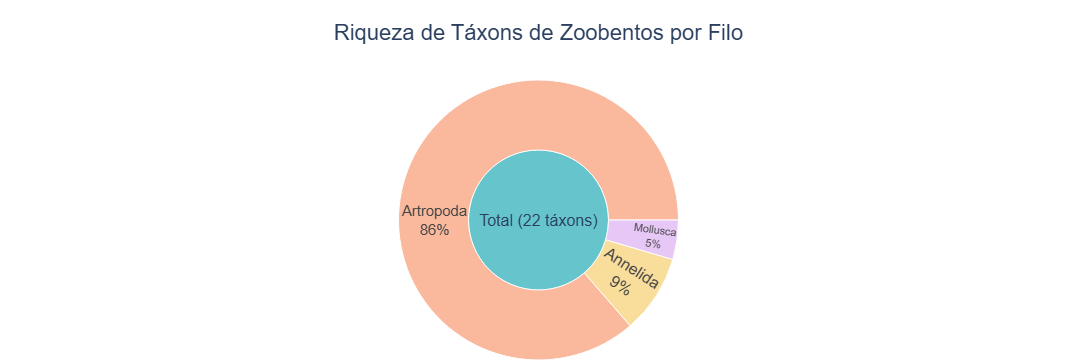

In [3]:
# --- Bloco 3: Gráfico Sunburst de Riqueza (Zoobentos) ---
import plotly.express as px

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Gráfico Sunburst de Riqueza ---")
    
    # 1. PREPARAÇÃO DOS DADOS
    # Lógica inteligente para escolher o melhor nível taxonômico para agrupar
    # Se a coluna 'filo' tiver mais de um valor único, ela será usada.
    # Caso contrário, ele tentará usar 'ordem', que é mais específico para Zoobentos.
    if df_zoo_limpo['filo'].nunique() > 1:
        nivel_taxonomico = 'filo'
    else:
        nivel_taxonomico = 'ordem'
        
    print(f"   -> Agrupando por '{nivel_taxonomico}' para a visualização.")
    
    # Prepara os dados para o gráfico
    sunburst_data = df_zoo_limpo.dropna(subset=[nivel_taxonomico, 'nome_cientifico']).groupby(nivel_taxonomico)['nome_cientifico'].nunique().reset_index(name='Riqueza')
    
    # Salva o arquivo de verificação
    salvar_check_excel(sunburst_data, 'dados_sunburst_zoobentos', caminho_saida_grupo)
    
    # Cria a raiz do gráfico (o círculo central)
    total_riqueza = sunburst_data['Riqueza'].sum()
    sunburst_data['Centro'] = f"Total ({total_riqueza} táxons)"

    # 2. CRIAÇÃO DO GRÁFICO COM PLOTLY
    fig = px.sunburst(
        sunburst_data,
        path=['Centro', nivel_taxonomico],
        values='Riqueza',
        color=nivel_taxonomico,
        color_discrete_sequence=px.colors.qualitative.Pastel,
    )

    # 3. CUSTOMIZAÇÃO
    fig.update_layout(
        title_text=f'Riqueza de Táxons de Zoobentos por {nivel_taxonomico.title()}',
        title_x=0.5,
        font=dict(family="Arial", size=16),
        margin=dict(t=80, l=0, r=0, b=0)
    )
    fig.update_traces(
        textinfo='label+percent root',
        insidetextorientation='radial',
        hovertemplate='<b>%{label}</b><br>Riqueza: %{value} táxons<br>Proporção da Riqueza Total: %{percentRoot:.1%}'
    )

    # 4. SALVAR E EXIBIR
    nome_arquivo_png = 'grafico_riqueza_sunburst_zoobentos.png'
    caminho_completo_png = os.path.join(caminho_saida_grupo, nome_arquivo_png)
    nome_arquivo_html = 'grafico_riqueza_sunburst_zoobentos_interativo.html'
    caminho_completo_html = os.path.join(caminho_saida_grupo, nome_arquivo_html)
    
    try:
        fig.write_image(caminho_completo_png, width=1000, height=1000, scale=2)
        print(f"   -> Imagem salva em: '{caminho_completo_png}'")
    except ValueError:
        print("   -> AVISO: 'kaleido' não instalado. Imagem .png não foi salva.")
    
    fig.write_html(caminho_completo_html)
    print(f"   -> HTML interativo salvo em: '{caminho_completo_html}'")
    fig.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Gráfico de Riqueza por Ponto Amostral ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_riqueza_ponto_zoobentos.xlsx'
   -> Gráfico salvo em: '..\03_relatorios\zoobentos\grafico_riqueza_ponto_zoobentos.png'


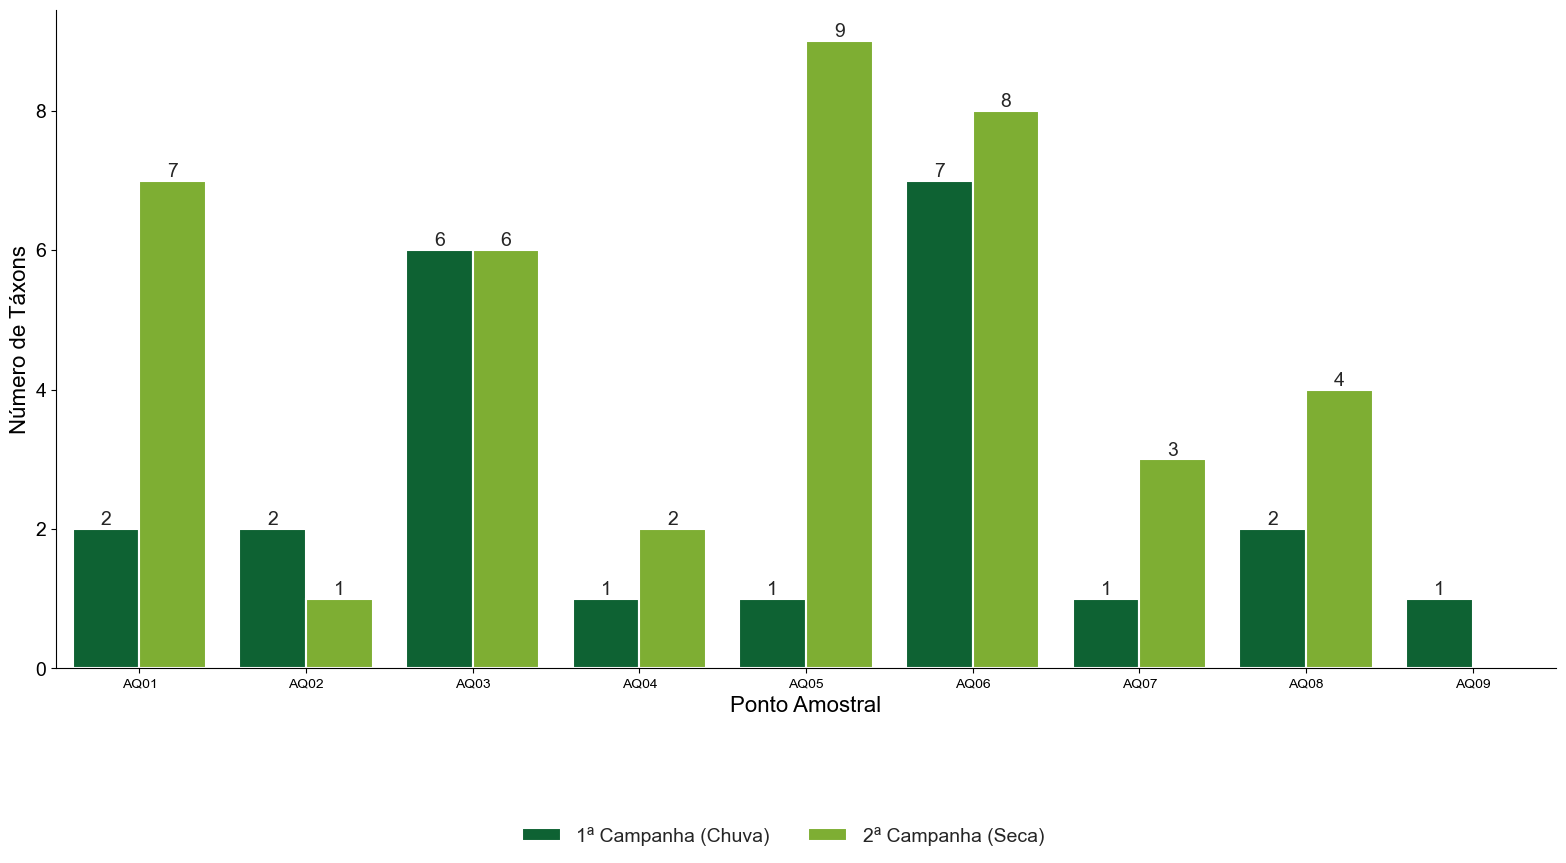

In [4]:
# --- Bloco 4 (Corrigido): Gráfico de Riqueza por Ponto Amostral (Zoobentos) ---

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Gráfico de Riqueza por Ponto Amostral ---")
    
    # 1. PREPARAÇÃO DOS DADOS
    # <<-- CORREÇÃO AQUI: Usamos 'nome_cientifico' em vez de 'taxon' -->>
    df_riqueza_ponto = df_zoo_limpo.groupby(['ponto_amostral', 'campanha'])['nome_cientifico'].nunique().reset_index()
    df_riqueza_ponto.rename(columns={'nome_cientifico': 'riqueza_de_taxons'}, inplace=True)
    
    # Salva o arquivo de verificação
    salvar_check_excel(df_riqueza_ponto, 'dados_riqueza_ponto_zoobentos', caminho_saida_grupo)
    
    # 2. CRIAÇÃO DO GRÁFICO
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.set_theme(style="white", context="talk")
    
    sns.barplot(
        data=df_riqueza_ponto,
        x='ponto_amostral',
        y='riqueza_de_taxons',
        hue='campanha',
        palette=["#007032", "#82C21F"],
        ax=ax,
        width=0.8
    )

    # 3. CUSTOMIZAÇÃO
    ax.set_ylabel("Número de Táxons", fontsize=16)
    ax.set_xlabel("Ponto Amostral", fontsize=16)
    ax.tick_params(axis='y', direction='out', left=True, labelsize=14)
    ax.grid(False)
    sns.despine(ax=ax)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=14)
        
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    handles, labels = ax.get_legend_handles_labels()
    novos_labels = [l.replace('1 ','1ª ',1).replace('2 ','2ª ',1) for l in labels]
    fig.legend(
        handles,
        novos_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=len(novos_labels),
        frameon=False,
        fontsize=14
    )
    
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    
    # 4. SALVAR O GRÁFICO
    nome_arquivo = 'grafico_riqueza_ponto_zoobentos.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    
    print(f"   -> Gráfico salvo em: '{caminho_completo}'")
    plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Gráfico de Riqueza por Grupo Taxonômico ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_riqueza_grupo_zoobentos.xlsx'
   -> Gráfico salvo em: '..\03_relatorios\zoobentos\grafico_riqueza_grupo_taxonomico_zoobentos.png'


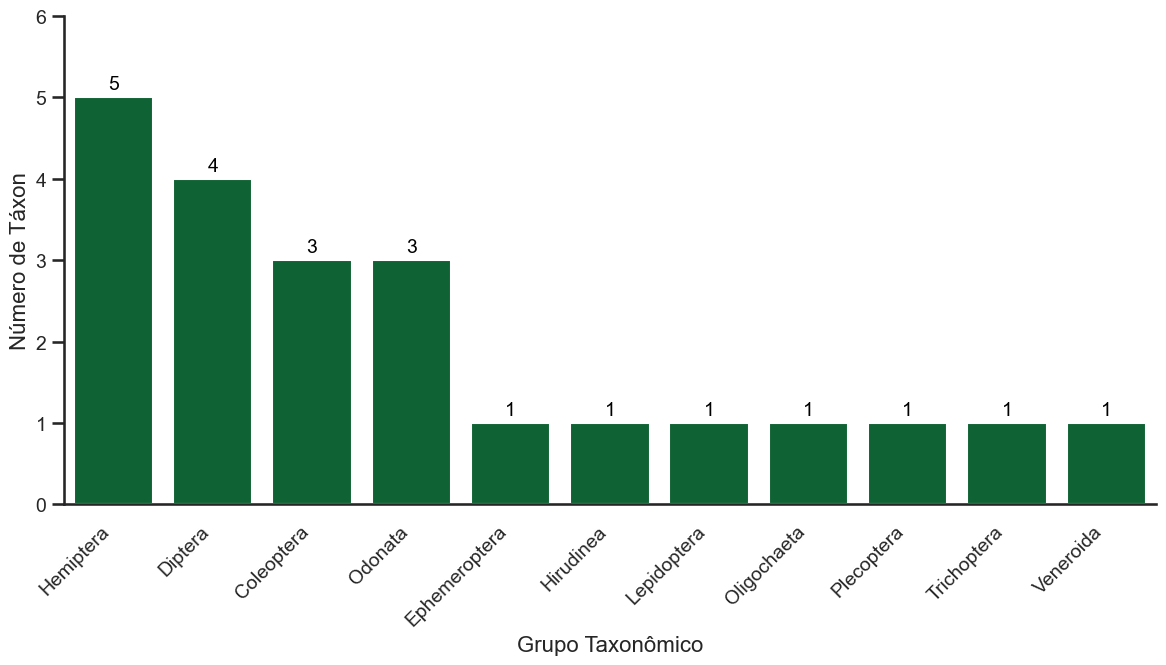

In [5]:
# --- Bloco 5: Gráfico de Riqueza por Grupo Taxonômico (Zoobentos) ---

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Gráfico de Riqueza por Grupo Taxonômico ---")
    
    # 1. PREPARAÇÃO DOS DADOS
    df_riqueza_grupo = df_zoo_limpo.copy()
    
    # <<-- LÓGICA PARA INCLUIR NÍVEIS HIERÁRQUICOS SUPERIORES -->>
    # Cria a coluna 'grupo_plotagem' usando a primeira identificação não nula (Ordem > Classe > Filo)
    df_riqueza_grupo['grupo_plotagem'] = df_riqueza_grupo['ordem'].fillna(df_riqueza_grupo['classe']).fillna(df_riqueza_grupo['filo'])
    
    # Remove registros que não tiveram NENHUMA dessas classificações
    df_riqueza_grupo.dropna(subset=['grupo_plotagem'], inplace=True)
    
    # Calcula a riqueza com base nesta nova coluna de agrupamento
    df_riqueza_final = df_riqueza_grupo.groupby('grupo_plotagem')['nome_cientifico'].nunique().reset_index()
    df_riqueza_final.rename(columns={'nome_cientifico': 'riqueza'}, inplace=True)
    
    # Ordena os grupos pela riqueza para um gráfico mais claro
    df_riqueza_final = df_riqueza_final.sort_values(by='riqueza', ascending=False)
    
    # Salva o arquivo de verificação
    salvar_check_excel(df_riqueza_final, 'dados_riqueza_grupo_zoobentos', caminho_saida_grupo)
    
    # 2. CRIAÇÃO DO GRÁFICO
    sns.set_theme(style="white", context="talk")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    sns.barplot(
        data=df_riqueza_final,
        x='grupo_plotagem',
        y='riqueza',
        color="#007032",
        ax=ax
    )
    
    # 3. CUSTOMIZAÇÃO
    for container in ax.containers:
        ax.bar_label(container, fontsize=14, fmt='%d', color='black', padding=3)
        
    ax.set_xlabel("Grupo Taxonômico", fontsize=16)
    ax.set_ylabel('Número de Táxon', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(False)
    sns.despine()
    ax.tick_params(axis='y', direction='out', left=True)
    
    y_max = df_riqueza_final['riqueza'].max()
    ax.set_ylim(0, y_max * 1.2)
    plt.tight_layout()
    
    # 4. SALVAR O GRÁFICO
    nome_arquivo = 'grafico_riqueza_grupo_taxonomico_zoobentos.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    
    print(f"   -> Gráfico salvo em: '{caminho_completo}'")
    plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Gráfico de Composição da Riqueza por Ordem ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_composicao_riqueza_zoobentos.xlsx'
   -> Gráfico base gerado.

_Gráfico salvo com sucesso em: '..\03_relatorios\zoobentos\grafico_composicao_riqueza_zoobentos.png'_


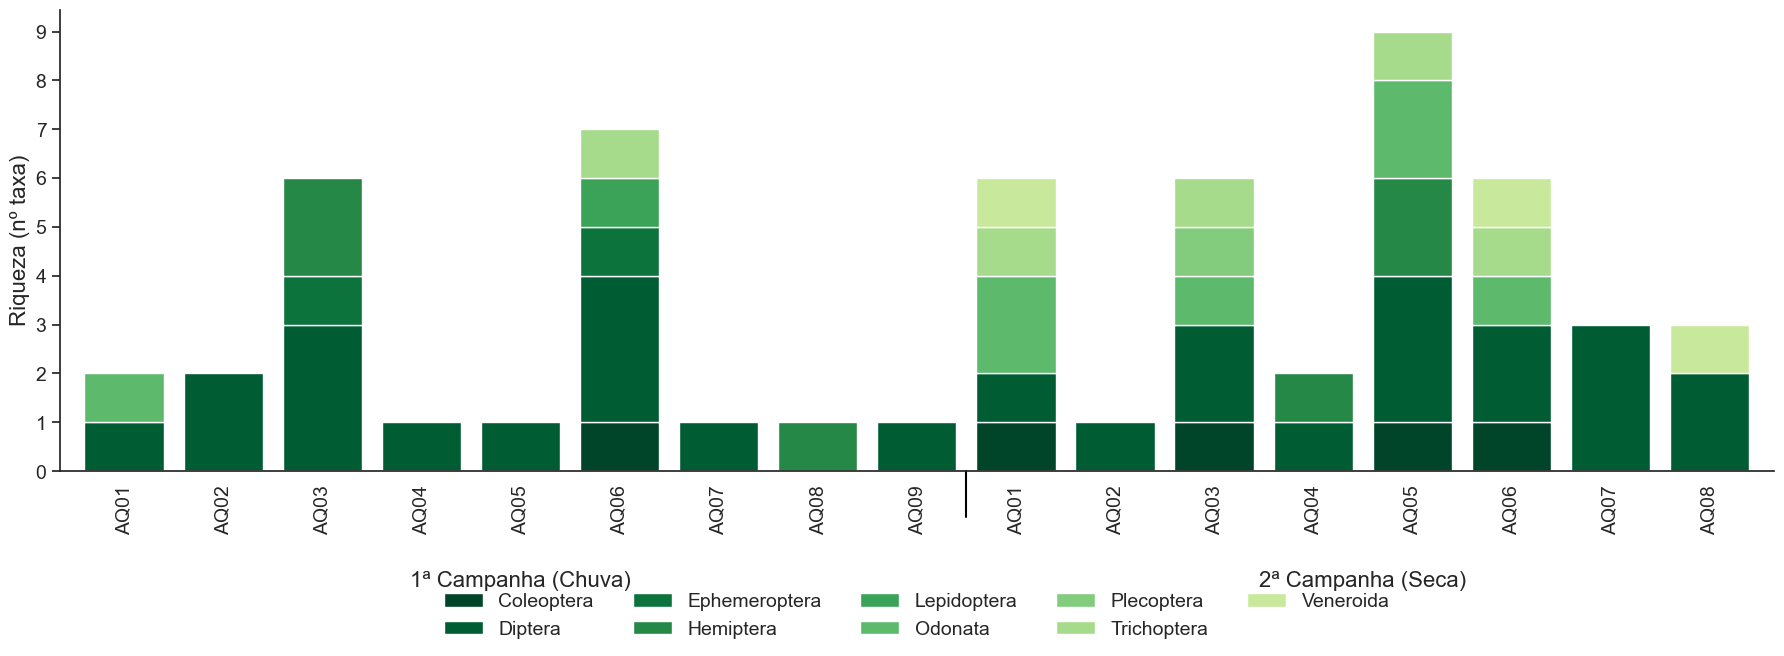

In [6]:
# --- Bloco 6 (Revisado Final): Gráfico de Composição da Riqueza por Ordem ---
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Gráfico de Composição da Riqueza por Ordem ---")
    
    # 1. PREPARAÇÃO DOS DADOS (inalterado)
    df_para_riqueza = df_zoo_limpo.copy()
    nivel_taxonomico = 'ordem'
    df_riqueza_grupo = df_para_riqueza.groupby(['campanha', 'ponto_amostral', nivel_taxonomico])['nome_cientifico'].nunique().reset_index()
    pivot_riqueza = df_riqueza_grupo.pivot_table(index=['campanha', 'ponto_amostral'], columns=nivel_taxonomico, values='nome_cientifico', fill_value=0)
    salvar_check_excel(pivot_riqueza.reset_index(), 'dados_composicao_riqueza_zoobentos', caminho_saida_grupo)

    # 2. CRIAÇÃO DO GRÁFICO (inalterado)
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(18, 9))
    n_grupos = len(pivot_riqueza.columns); cmap = plt.get_cmap('YlGn_r'); cores = [cmap(i) for i in np.linspace(0.0, 0.7, n_grupos)]
    pivot_riqueza.plot(kind='bar', stacked=True, ax=ax, color=cores, width=0.8)
    print("   -> Gráfico base gerado.")

    # 3. CUSTOMIZAÇÃO (com o novo separador)
    ax.set_ylabel('Riqueza (nº taxa)', fontsize=16)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, steps=[1, 2, 5]))
    ax.tick_params(axis='y', labelsize=14, direction='out', left=True)
    ax.set_xlabel(None)
    ax.set_xticklabels([p[1] for p in pivot_riqueza.index], rotation=90, ha='center', fontsize=14)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=5, frameon=False, fontsize=14, title=None)
    ax.grid(False)
    sns.despine()
    
    # <<-- MUDANÇA PRINCIPAL AQUI: Lógica da Linha Separadora Inferior -->>
    espessura_eixo = ax.spines['bottom'].get_linewidth()
    boundaries = [0]; campanhas = pivot_riqueza.index.get_level_values('campanha')
    for i in range(1, len(campanhas)):
        if campanhas[i] != campanhas[i-1]:
            posicao_linha = i - 0.5
            ax.plot([posicao_linha, posicao_linha], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax.get_xaxis_transform(), clip_on=False)
            boundaries.append(i)
    
    boundaries.append(len(campanhas))
    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i+1]; mid = start + (end-start)/2 - 0.5
        label = campanhas[start].replace('1 ','1ª ',1).replace('2 ','2ª ',1)
        ax.text(mid, -0.25, label, ha='center', transform=ax.get_xaxis_transform(), fontsize=16)

    plt.tight_layout(rect=[0, 0.15, 1, 1])

    # 4. SALVAR O GRÁFICO (inalterado)
    nome_arquivo = 'grafico_composicao_riqueza_zoobentos.png'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_")
    
    plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")

In [7]:
# --- Bloco 7 (Final e Validado): Tabela de Ocorrência (Zoobentos) ---

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Tabela de Ocorrência ---")
    
    campanhas_ordenadas = sorted(df_zoo_limpo['campanha'].unique())
    pontos_ordenados = sorted(df_zoo_limpo['ponto_amostral'].unique())
    especies_ordenadas = sorted(df_zoo_limpo['nome_cientifico'].dropna().unique())
    lista_tabelas_por_campanha = []

    for campanha in campanhas_ordenadas:
        df_campanha_atual = df_zoo_limpo[df_zoo_limpo['campanha'] == campanha]
        tabela_base = pd.DataFrame(index=especies_ordenadas, columns=pontos_ordenados)
        
        df_quant = df_campanha_atual[df_campanha_atual['tipo_amostragem'] == 'Quantitativa']
        matriz_quant = df_quant.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='abundancia', aggfunc='sum')
        
        # Como não há dados qualitativos, df_qual ficará vazio, e matriz_qual também.
        df_qual = df_campanha_atual[df_campanha_atual['tipo_amostragem'].isin(['Qualitativo', 'Qualitativa'])]
        matriz_qual = df_qual.pivot_table(index='nome_cientifico', columns='ponto_amostral', values='abundancia', aggfunc=lambda x: 'X')

        # O código preenche a base com a matriz_qual (vazia) e depois com a matriz_quant (com dados)
        tabela_pivot_completa = tabela_base.fillna(matriz_qual)
        tabela_pivot_completa.fillna(matriz_quant, inplace=True)
        
        # O resto do cálculo segue normalmente
        total_pontos = len(pontos_ordenados)
        tabela_pivot_completa['OC'] = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=1)
        if total_pontos > 0:
            tabela_pivot_completa['%OC'] = (tabela_pivot_completa['OC'] / total_pontos) * 100
        else:
            tabela_pivot_completa['%OC'] = 0
        
        abundancia_total = tabela_pivot_completa[pontos_ordenados].apply(pd.to_numeric, errors='coerce').sum(axis=0)
        abundancia_total.name = 'Abundância Total'
        riqueza = tabela_pivot_completa[pontos_ordenados].notna().sum(axis=0)
        riqueza.name = 'Riqueza'
        
        tabela_campanha_final = pd.concat([tabela_pivot_completa.astype(object), abundancia_total.to_frame().T.astype(object), riqueza.to_frame().T.astype(object)])
        lista_tabelas_por_campanha.append(tabela_campanha_final)

    if lista_tabelas_por_campanha:
        tabela_final = pd.concat(lista_tabelas_por_campanha, axis=1, keys=campanhas_ordenadas)
        tabela_final.index.name = 'Espécie'
        tabela_final = tabela_final.astype(object).fillna('')
        for campanha in campanhas_ordenadas:
            col_oc_percent = (campanha, '%OC')
            if col_oc_percent in tabela_final.columns:
                 tabela_final[col_oc_percent] = tabela_final[col_oc_percent].apply(lambda x: f"{float(x):.0f}%" if x != '' else '')
        
        nome_arquivo = 'tabela_ocorrencia_zoobentos.xlsx'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        tabela_final.to_excel(caminho_completo, sheet_name='Ocorrencia_Zoobentos')
        
        print(f"   -> Tabela de Ocorrência salva em: '{caminho_completo}'")
        display(tabela_final)

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Tabela de Ocorrência ---
   -> Tabela de Ocorrência salva em: '..\03_relatorios\zoobentos\tabela_ocorrencia_zoobentos.xlsx'


1 Campanha (Chuva)                                        \
                               AQ01 AQ02  AQ03 AQ04  AQ05  AQ06 AQ07 AQ08   
Espécie                                                                     
Aeshnidae                                                                   
Baetidae                                   1.0              6.0             
Belostomatidae                                                        1.0   
Ceratopogonidae                      2.0        4.0         1.0             
Chironomidae                    1.0  1.0   6.0       23.0   1.0  1.0        
Elmidae                                                     4.0             
Gerridae                                   1.0                              
Gomphidae                       1.0                                         
Hirudinea                                                                   
Hydrophilidae                                                               
Hydropsychidae                                              4.0             
Libellulidae                                                                
Naucoridae                                                                  
Notonectidae                               6.0                              
Oligochaeta                                                           1.0   
Perlidae                                                                    
Psephenidae                                                                 
Pyralidae                                                   1.0             
Simuliidae                                 2.0              8.0             
Sphaerium spp.                                                              
Tipulidae                                  4.0                              
Veliidae                                                                    
Abundância Total                2.0  3.0  20.0  4.0  23.0  25.0  1.0  2.0   
Riqueza                           2    2     6    1     1     7    1    2   

                          ... 2 Campanha (Seca)                               \
                 AQ09 OC  ...              AQ02  AQ03 AQ04  AQ05  AQ06  AQ07   
Espécie                   ...                                                  
Aeshnidae              0  ...                                                  
Baetidae               2  ...                                                  
Belostomatidae         1  ...                                                  
Ceratopogonidae        3  ...                          7.0   4.0         7.0   
Chironomidae      1.0  7  ...               1.0   3.0        4.0   2.0   3.0   
Elmidae                1  ...                                9.0   3.0         
Gerridae               1  ...                                                  
Gomphidae              1  ...                                1.0   1.0         
Hirudinea              0  ...                                      3.0         
Hydrophilidae          0  ...                                                  
Hydropsychidae         1  ...                     2.0        1.0   2.0         
Libellulidae           0  ...                     2.0        2.0               
Naucoridae             0  ...                          1.0   7.0               
Notonectidae           1  ...                                                  
Oligochaeta            1  ...                                      1.0         
Perlidae               0  ...                     1.0                          
Psephenidae            0  ...                     1.0                          
Pyralidae              1  ...                                                  
Simuliidae             2  ...                                3.0  22.0         
Sphaerium spp.         0  ...                                      1.0         
Tipulidae              1  ...                     7.0                    2.0   
Veliidae         


--- Gerando: Gráfico de Diversidade e Equitabilidade ---
   -> AVISO: Riqueza = 1 encontrada. Forçando Equitabilidade para 0.0 nas amostras: ['AQ09']
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_diversidade_zoobentos.xlsx'
   -> Gerando o gráfico...

_Gráfico salvo com sucesso em: '..\03_relatorios\zoobentos\grafico_diversidade_equitabilidade_zoobentos.png'_


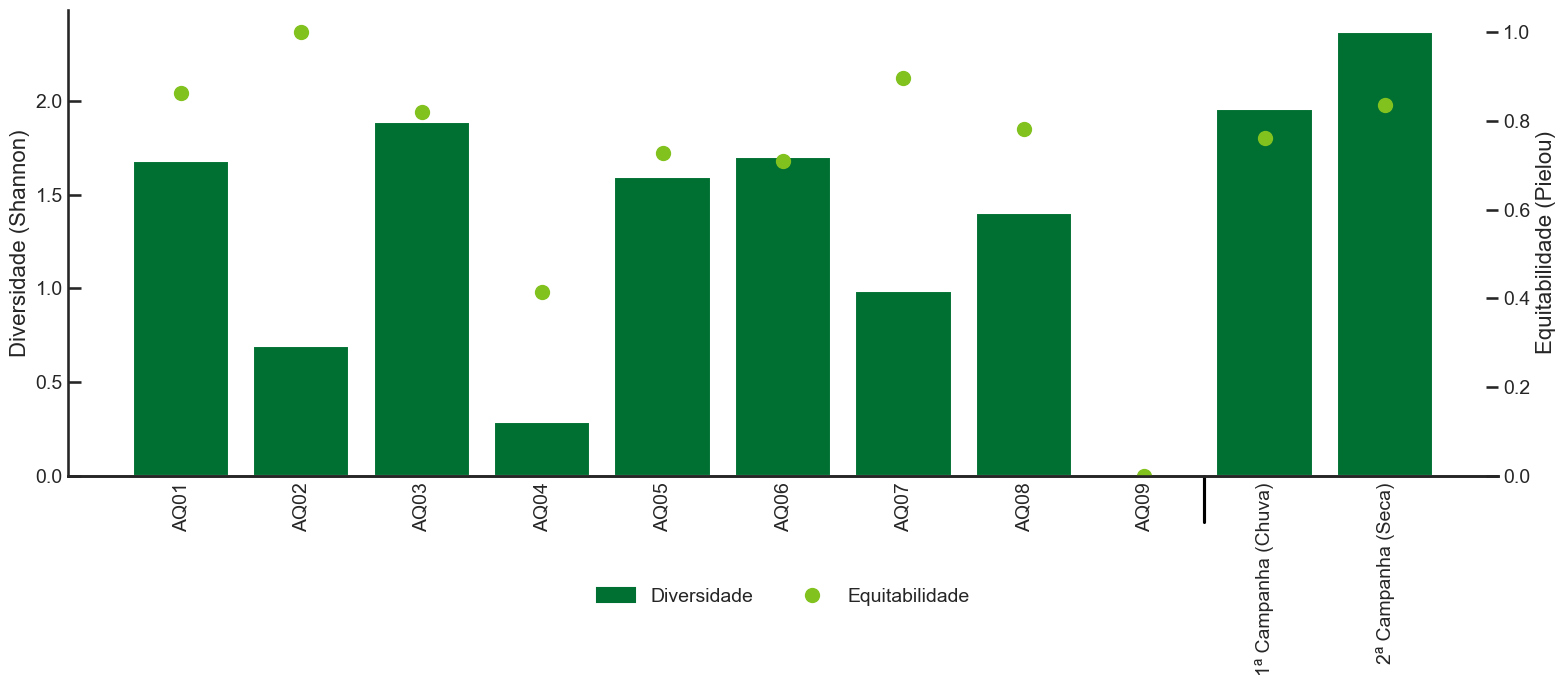

In [8]:
# --- Bloco 8 (Revisado): Gráfico de Diversidade com Equitabilidade Forçada para Zero ---
import skbio.diversity
from matplotlib.patches import Patch

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Gráfico de Diversidade e Equitabilidade ---")
    
    df_quant = df_zoo_limpo[df_zoo_limpo['tipo_amostragem'] == 'Quantitativa'].copy()
    
    if df_quant.empty or df_quant['abundancia'].sum() == 0:
        print("   -> AVISO: Nenhum dado quantitativo com abundância > 0 foi encontrado. Gráfico não será gerado.")
    else:
        # 1. PREPARAÇÃO DAS MATRIZES (inalterado)
        matriz_pontos = df_quant.pivot_table(index='ponto_amostral', columns='nome_cientifico', values='abundancia', aggfunc='sum', fill_value=0)
        matriz_pontos = matriz_pontos.loc[matriz_pontos.sum(axis=1) > 0]
        matriz_campanhas = df_quant.pivot_table(index='campanha', columns='nome_cientifico', values='abundancia', aggfunc='sum', fill_value=0)
        matriz_total = pd.concat([matriz_pontos, matriz_campanhas])
        
        # 2. CÁLCULO DOS ÍNDICES (inalterado)
        shannon_h = matriz_total.apply(lambda row: skbio.diversity.alpha.shannon(row, base=np.e), axis=1)
        pielou_j = matriz_total.apply(lambda row: skbio.diversity.alpha.pielou_e(row), axis=1)
        df_resultados_div = pd.DataFrame({'Diversidade': shannon_h, 'Equitabilidade': pielou_j})
        
        # <<-- INÍCIO DA NOVA LÓGICA: Regra de Negócio para Equitabilidade -->>
        # a) Calcula a riqueza para cada amostra na matriz_total
        riqueza_por_amostra = (matriz_total > 0).sum(axis=1)
        
        # b) Identifica as amostras onde a riqueza é igual a 1
        amostras_riqueza_1 = riqueza_por_amostra[riqueza_por_amostra == 1].index
        
        # c) Força a Equitabilidade para 0 nessas amostras específicas
        if not amostras_riqueza_1.empty:
            print(f"   -> AVISO: Riqueza = 1 encontrada. Forçando Equitabilidade para 0.0 nas amostras: {list(amostras_riqueza_1)}")
            df_resultados_div.loc[amostras_riqueza_1, 'Equitabilidade'] = 0.0
        # <<-- FIM DA NOVA LÓGICA -->>

        salvar_check_excel(df_resultados_div.reset_index(), 'dados_diversidade_zoobentos', caminho_saida_grupo)

        # 3. VISUALIZAÇÃO DO GRÁFICO (inalterado)
        print("   -> Gerando o gráfico...")
        sns.set_theme(style="white", context="talk"); fig, ax1 = plt.subplots(figsize=(16, 8))
        cor_diversidade = "#007032"; cor_equitabilidade = "#82C21F"
        ax1.bar(df_resultados_div.index, df_resultados_div['Diversidade'], color=cor_diversidade)
        ax1.set_ylabel('Diversidade (Shannon)', fontsize=16); ax1.tick_params(axis='y', labelsize=14, direction='in'); ax1.set_xlabel(None)
        rotulos_x_formatados = [label.replace('1 ', '1ª ', 1).replace('2 ', '2ª ', 1) for label in df_resultados_div.index]; ax1.set_xticks(range(len(rotulos_x_formatados))); ax1.set_xticklabels(rotulos_x_formatados, rotation=90, ha='center', fontsize=14); ax1.tick_params(axis='x', direction='in', pad=5)
        ax2 = ax1.twinx(); ax2.plot(df_resultados_div.index, df_resultados_div['Equitabilidade'], marker='o', linestyle='None', color=cor_equitabilidade, markersize=10); ax2.set_ylabel('Equitabilidade (Pielou)', fontsize=16); ax2.set_ylim(0, 1.05); ax2.tick_params(axis='y', labelsize=14, direction='in')
        posicao_linha = len(matriz_pontos) - 0.5; espessura_eixo = ax1.spines['bottom'].get_linewidth(); ax1.plot([posicao_linha, posicao_linha], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax1.get_xaxis_transform(), clip_on=False)
        ax1.grid(False); ax2.grid(False); sns.despine(ax=ax1); sns.despine(ax=ax2, left=True)
        patch_handle = Patch(color=cor_diversidade, label='Diversidade'); line_handle = ax2.get_lines()[0]; line_handle.set_label('Equitabilidade'); fig.legend(handles=[patch_handle, line_handle], loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2, frameon=False, fontsize=14)
        plt.tight_layout(rect=[0, 0.1, 1, 1])

        # 4. SALVAR O GRÁFICO
        nome_arquivo = 'grafico_diversidade_equitabilidade_zoobentos.png'; caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
        print(f"\n_Gráfico salvo com sucesso em: '{caminho_completo}'_"); plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Dendrograma de Similaridade ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_matriz_similaridade_zoobentos.xlsx'
   -> Matriz de comunidade criada com 9 pontos amostrais.
   -> Agrupamento hierárquico realizado.
   -> Gerando o dendrograma com eixo de Similaridade...

_Dendrograma salvo com sucesso em: '..\03_relatorios\zoobentos\dendrograma_similaridade_zoobentos.png'_


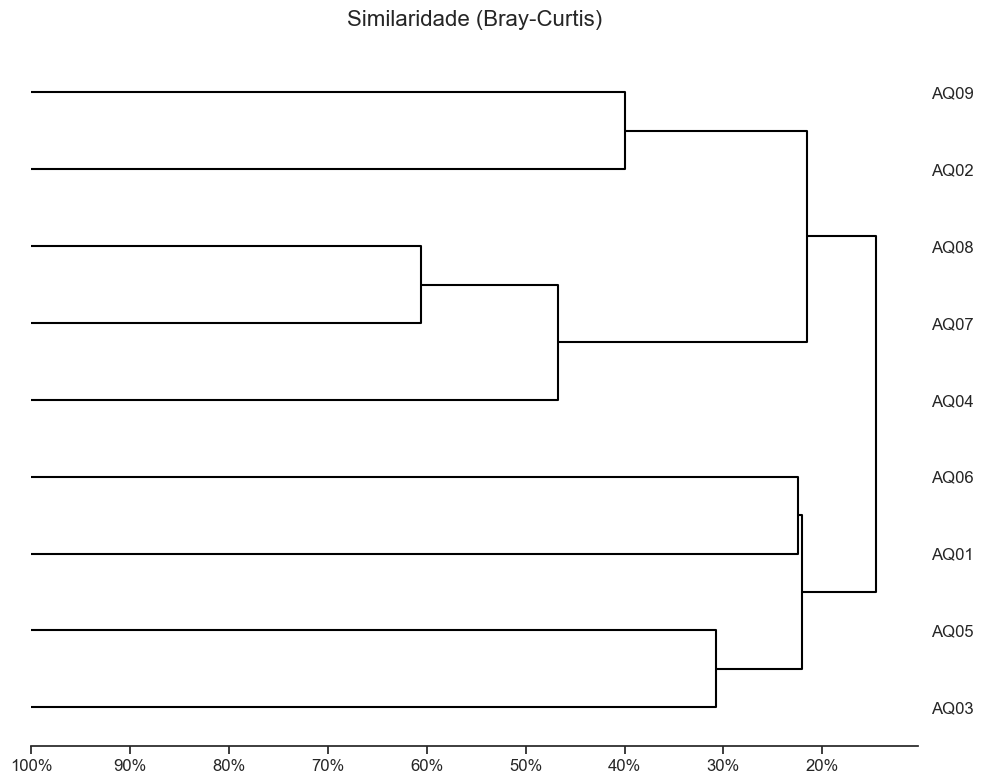

In [9]:
# --- Bloco 9: Análise de Similaridade (Dendrograma de Bray-Curtis) para Zoobentos ---
from scipy.cluster.hierarchy import linkage, dendrogram
import skbio.diversity
import matplotlib.ticker as mticker

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Dendrograma de Similaridade ---")
    
    # 1. PREPARAÇÃO DOS DADOS (APENAS QUANTITATIVOS)
    df_quant = df_zoo_limpo[df_zoo_limpo['tipo_amostragem'] == 'Quantitativa'].copy()
    
    if df_quant.empty or df_quant['abundancia'].sum() == 0:
        print("   -> AVISO: Nenhum dado quantitativo encontrado. Análise não será gerada.")
    else:
        # Cria a matriz de comunidade, agregando dados de todas as campanhas por ponto.
        matriz_similaridade = df_quant.pivot_table(
            index='ponto_amostral',
            columns='nome_cientifico',
            values='abundancia',
            aggfunc='sum',
            fill_value=0
        )
        matriz_similaridade = matriz_similaridade.loc[matriz_similaridade.sum(axis=1) > 0]
        
        if matriz_similaridade.shape[0] <= 1:
             print("   -> AVISO: Apenas uma amostra com dados válidos encontrada. Não é possível calcular a similaridade.")
        else:
            salvar_check_excel(matriz_similaridade.reset_index(), 'dados_matriz_similaridade_zoobentos', caminho_saida_grupo)
            print(f"   -> Matriz de comunidade criada com {matriz_similaridade.shape[0]} pontos amostrais.")

            # 2. CÁLCULO E AGRUPAMENTO
            distancia_bc = skbio.diversity.beta_diversity('braycurtis', matriz_similaridade.values, ids=matriz_similaridade.index)
            distancia_condensada = distancia_bc.condensed_form()
            linked = linkage(distancia_condensada, method='average')
            print("   -> Agrupamento hierárquico realizado.")

            # 3. GERAR E CUSTOMIZAR O DENDROGRAMA
            print("   -> Gerando o dendrograma com eixo de Similaridade...")
            sns.set_theme(style="white")
            fig, ax = plt.subplots(figsize=(10, 8))

            dendrogram(
                linked,
                orientation='left',
                labels=matriz_similaridade.index.tolist(),
                ax=ax,
                color_threshold=0,
                above_threshold_color='black'
            )
            
            # Lógica para converter o eixo para Similaridade em %
            ax.invert_xaxis()
            def format_similarity(x, pos):
                return f'{(1 - x) * 100:.0f}%'
            ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_similarity))

            # Customização do estilo
            ax.set_title('Similaridade (Bray-Curtis)', loc='center', fontsize=16, fontname='Arial', pad=20)
            ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=12)
            ax.tick_params(axis='y', which='both', left=False, right=False, labelsize=12)
            ax.grid(False)
            sns.despine(left=True)

            plt.tight_layout()

            # 4. SALVAR O GRÁFICO
            nome_arquivo = 'dendrograma_similaridade_zoobentos.png'
            caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
            plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
            
            print(f"\n_Dendrograma salvo com sucesso em: '{caminho_completo}'_")
            plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Curva de Suficiência Amostral ---
   -> Matriz de presença/ausência criada com 17 unidades amostrais.
   -> Iniciando simulação com 100 randomizações...
   -> Simulação concluída.
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_curva_suficiencia_zoobentos.xlsx'
   -> Gerando o gráfico...

_Gráfico de Suficiência Amostral salvo em: '..\03_relatorios\zoobentos\grafico_suficiencia_amostral_zoobentos.png'_


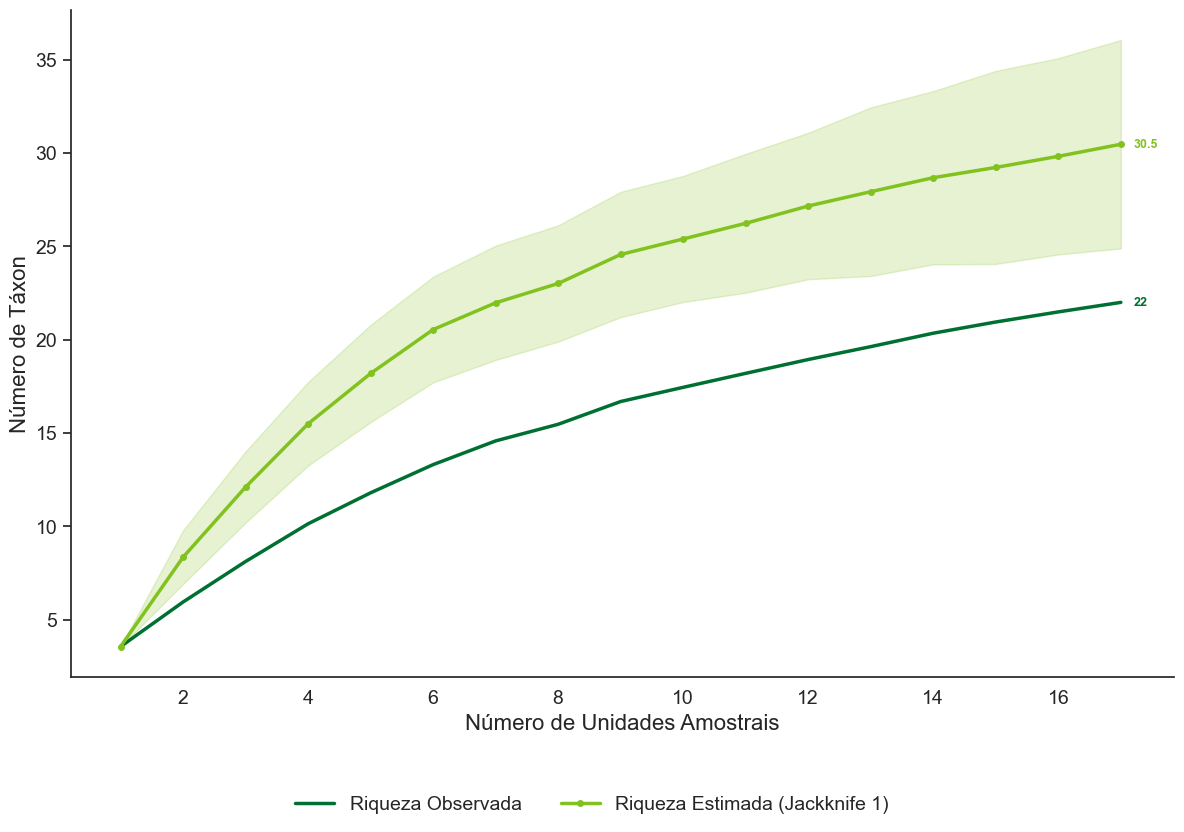

In [10]:
# --- Bloco 10: Curva de Suficiência Amostral (Zoobentos) ---
from matplotlib.lines import Line2D

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Curva de Suficiência Amostral ---")
    
    # 1. PREPARAÇÃO DOS DADOS (baseado em presença/ausência)
    df_suficiencia = df_zoo_limpo.copy()
    df_suficiencia['presenca'] = 1
    matriz_suficiencia = df_suficiencia.pivot_table(
        index=['campanha', 'ponto_amostral'],
        columns='nome_cientifico',
        values='presenca',
        aggfunc='max',
        fill_value=0
    )
    n_samples = matriz_suficiencia.shape[0]
    
    if n_samples <= 1:
        print(f"   -> AVISO: Apenas {n_samples} amostra(s) encontrada(s). Não é possível gerar a curva.")
    else:
        print(f"   -> Matriz de presença/ausência criada com {n_samples} unidades amostrais.")
        
        # 2. FUNÇÃO E SIMULAÇÃO
        def jackknife_1_estimator(matrix):
            S_obs = (matrix.sum(axis=0) > 0).sum(); k = matrix.shape[0]
            if k == 0: return 0
            uniques = (matrix > 0).sum(axis=0); Q1 = (uniques == 1).sum()
            return S_obs + Q1 * ((k - 1) / k)
        
        n_randomizations = 100
        sobs_curves = np.zeros((n_randomizations, n_samples))
        sest_curves = np.zeros((n_randomizations, n_samples))
        print(f"   -> Iniciando simulação com {n_randomizations} randomizações...")
        
        for rand in range(n_randomizations):
            shuffled_indices = np.random.permutation(n_samples)
            shuffled_matrix = matriz_suficiencia.iloc[shuffled_indices]
            for i in range(1, n_samples + 1):
                subset = shuffled_matrix.iloc[:i, :]
                sobs_curves[rand, i-1] = (subset.sum(axis=0) > 0).sum()
                sest_curves[rand, i-1] = jackknife_1_estimator(subset)
        
        # 3. AGREGAÇÃO E ORDENAÇÃO
        mean_sobs = sobs_curves.mean(axis=0)
        mean_sest = sest_curves.mean(axis=0)
        std_sest_original = sest_curves.std(axis=0)
        std_sest_ordenado = np.sort(std_sest_original)
        print("   -> Simulação concluída.")

        df_resultados_curvas = pd.DataFrame({
            'Numero_Amostras': np.arange(1, n_samples + 1),
            'Riqueza_Observada_Media': mean_sobs,
            'Riqueza_Estimada_Media': mean_sest,
            'Desvio_Padrao_Estimado_Ordenado': std_sest_ordenado
        })
        salvar_check_excel(df_resultados_curvas, 'dados_curva_suficiencia_zoobentos', caminho_saida_grupo)

        # 4. GERAÇÃO DO GRÁFICO
        print("   -> Gerando o gráfico...")
        sns.set_theme(style="white"); fig, ax = plt.subplots(figsize=(12, 8))
        x_axis = np.arange(1, n_samples + 1); cor_rarefacao = "#007032"; cor_estimada = "#82C21F"
        
        ax.plot(x_axis, mean_sobs, color=cor_rarefacao, linewidth=2.5, label='Riqueza Observada')
        ax.plot(x_axis, mean_sest, color=cor_estimada, linewidth=2.5, label='Riqueza Estimada (Jackknife 1)', marker='o', markersize=4)
        ax.fill_between(x_axis, mean_sest - std_sest_ordenado, mean_sest + std_sest_ordenado, color=cor_estimada, alpha=0.2)
        
        valor_final_obs = mean_sobs[-1]; valor_final_est = mean_sest[-1]
        ax.text(n_samples + 0.2, valor_final_obs, f'{valor_final_obs:.0f}', color=cor_rarefacao, fontsize=9, va='center', weight='bold')
        ax.text(n_samples + 0.2, valor_final_est, f'{valor_final_est:.1f}', color=cor_estimada, fontsize=9, va='center', weight='bold')
        ax.set_xlim(right=n_samples * 1.05)
        
        ax.set_xlabel('Número de Unidades Amostrais', fontsize=16); ax.set_ylabel('Número de Táxon', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14); ax.tick_params(axis='y', direction='out', left=True)
        sns.despine()
        
        if ax.get_legend() is not None: ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels(); fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=14)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        
        # 5. SALVAR O GRÁFICO
        nome_arquivo = 'grafico_suficiencia_amostral_zoobentos.png'
        caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
        plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
        
        print(f"\n_Gráfico de Suficiência Amostral salvo em: '{caminho_completo}'_")
        plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Análise do Índice BMWP por Campanha ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_bmwp_por_campanha.xlsx'

_Gráfico BMWP salvo em: '..\03_relatorios\zoobentos\grafico_bmwp_por_campanha_zoobentos.png'_


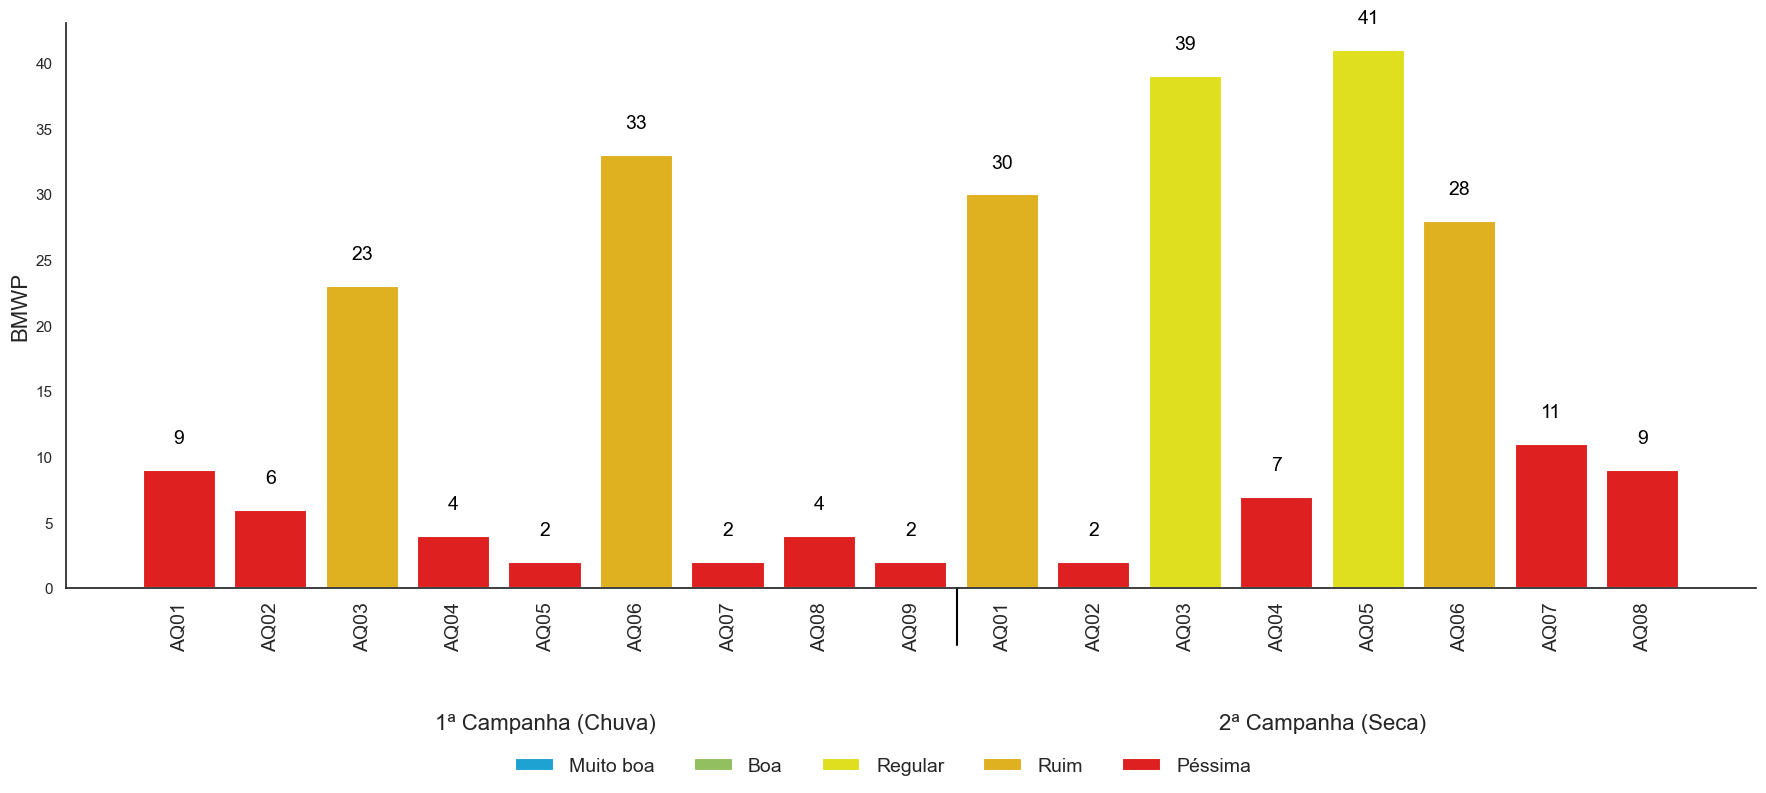

In [11]:
# --- Bloco 11 (Revisado Final): Índice BMWP por Campanha ---

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Análise do Índice BMWP por Campanha ---")
    
    df_taxons_unicos = df_zoo_limpo.drop_duplicates(subset=['campanha', 'ponto_amostral', 'nome_cientifico'])
    bmwp_scores = df_taxons_unicos.groupby(['campanha', 'ponto_amostral'])['bmwp_score'].sum().reset_index()
    salvar_check_excel(bmwp_scores, 'dados_bmwp_por_campanha', caminho_saida_grupo)
    
    def classificar_bmwp_revisado(score):
        if score > 85: return 'Muito boa'
        if score >= 64: return 'Boa'
        if score >= 37: return 'Regular'
        if score >= 17: return 'Ruim'
        return 'Péssima'
    bmwp_scores['Classificação'] = bmwp_scores['bmwp_score'].apply(classificar_bmwp_revisado)
    cores_map_bmwp = {'Muito boa': '#00b0f0', 'Boa': '#92d050', 'Regular': '#ffff00', 'Ruim': '#ffc000', 'Péssima': '#ff0000'}
    ordem_legenda_bmwp = ['Muito boa', 'Boa', 'Regular', 'Ruim', 'Péssima']
    bmwp_scores['eixo_x'] = bmwp_scores['campanha'] + "_" + bmwp_scores['ponto_amostral']
    
    fig, ax = plt.subplots(figsize=(18, 9)); sns.set_theme(style="white", context="talk")
    sns.barplot(data=bmwp_scores, x='eixo_x', y='bmwp_score', hue='Classificação', 
                palette=cores_map_bmwp, hue_order=ordem_legenda_bmwp, ax=ax, dodge=False)
    
    ax.set_xlabel(None); ax.set_ylabel('BMWP', fontsize=16); ax.grid(False); sns.despine(ax=ax)
    
    # <<-- CORREÇÃO AQUI: Define as posições antes de definir os rótulos -->>
    rotulos_x = [ponto.split('_')[1] for ponto in bmwp_scores['eixo_x']]
    ax.set_xticks(range(len(rotulos_x))) # Define AS POSIÇÕES (0, 1, 2...)
    ax.set_xticklabels(rotulos_x, rotation=90, ha='center', fontsize=14) # Define OS TEXTOS
    
    for index, row in bmwp_scores.iterrows():
        ax.text(index, row.bmwp_score + 2, f'{row.bmwp_score:.0f}', color='black', ha="center", fontsize=14)
    
    campanhas = bmwp_scores['campanha']
    boundaries = [0]
    for i in range(1, len(campanhas)):
        if campanhas[i] != campanhas[i-1]:
            posicao_linha = i - 0.5; espessura_eixo = ax.spines['bottom'].get_linewidth()
            ax.plot([posicao_linha, posicao_linha], [0, -0.10], color='black', linewidth=espessura_eixo * 1.2, transform=ax.get_xaxis_transform(), clip_on=False)
            boundaries.append(i)
    boundaries.append(len(campanhas))
    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i+1]; mid_point = start + (end - start) / 2 - 0.5
        label_text = campanhas[start].replace('1 ', '1ª ', 1).replace('2 ', '2ª ', 1)
        ax.text(mid_point, -0.25, label_text, ha='center', transform=ax.get_xaxis_transform(), fontsize=16)

    if ax.get_legend() is not None: ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=5, frameon=False, fontsize=14)
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    nome_arquivo = 'grafico_bmwp_por_campanha_zoobentos.png'; caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight'); print(f"\n_Gráfico BMWP salvo em: '{caminho_completo}'_"); plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")


--- Gerando: Análise dos Índices %EPT e %CHOL (Barras 100% Empilhadas) ---
   -> Arquivo de verificação salvo em: '..\03_relatorios\zoobentos\check\check_dados_ept_chol_empilhado.xlsx'

_Gráfico %EPT e %CHOL salvo em: '..\03_relatorios\zoobentos\grafico_ept_chol_empilhado_zoobentos.png'_


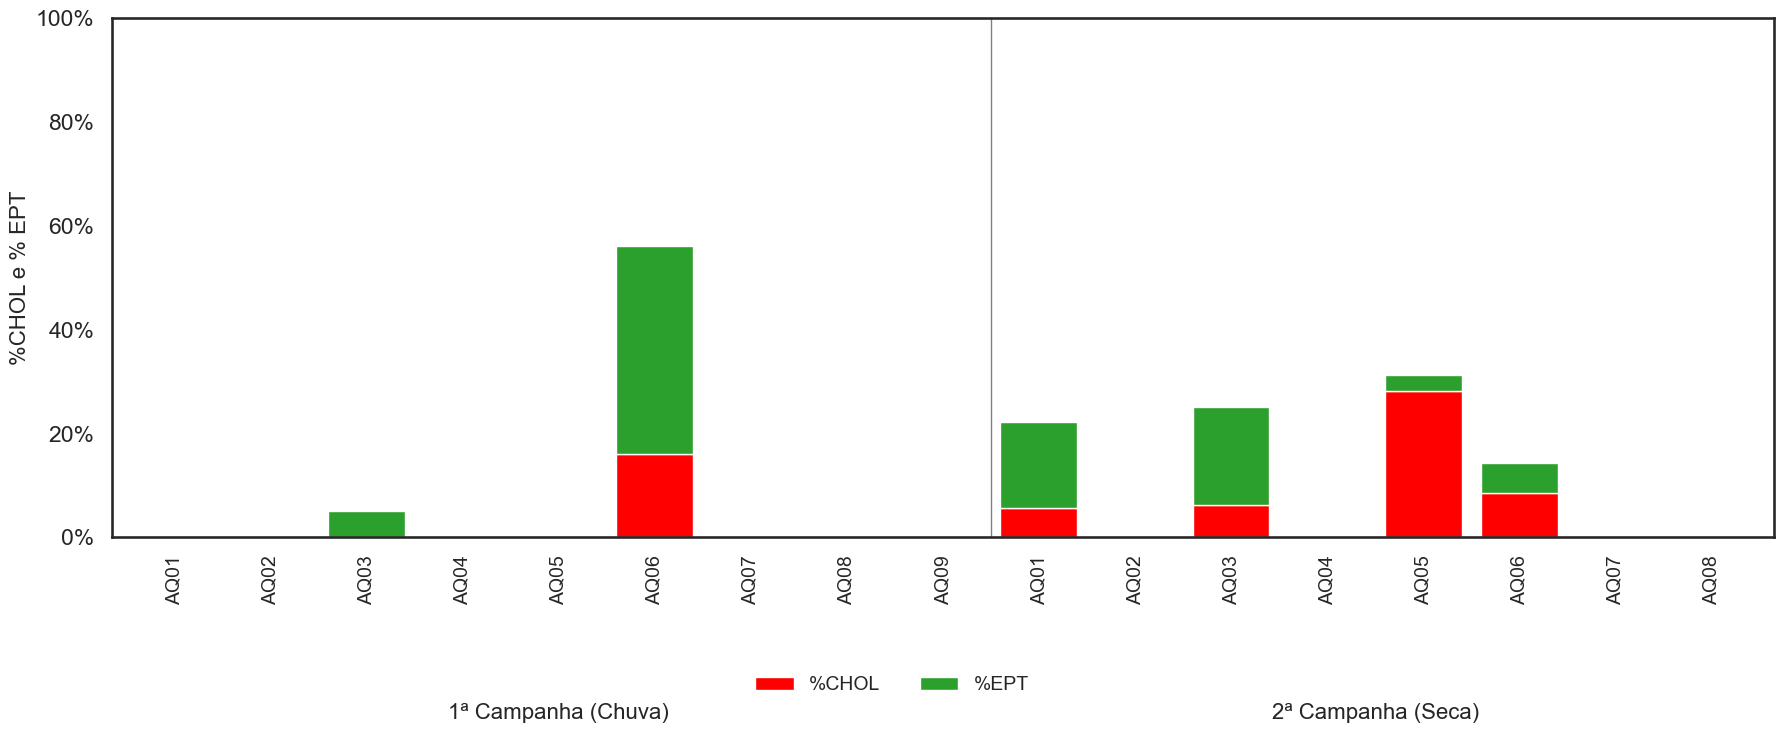

In [12]:
# --- Bloco 12 (Revisado): %EPT e %CHOL com Legenda Ajustada ---
import matplotlib.ticker as mticker

if 'df_zoo_limpo' in locals() and not df_zoo_limpo.empty:
    print("\n--- Gerando: Análise dos Índices %EPT e %CHOL (Barras 100% Empilhadas) ---")
    
    # 1. CÁLCULO DOS ÍNDICES (inalterado)
    abundancia_total_amostra = df_zoo_limpo.groupby(['campanha', 'ponto_amostral'])['abundancia'].sum()
    ordens_ept = ['Ephemeroptera', 'Plecoptera', 'Trichoptera']
    abundancia_ept = df_zoo_limpo[df_zoo_limpo['ordem'].isin(ordens_ept)].groupby(['campanha', 'ponto_amostral'])['abundancia'].sum()
    abundancia_chol = df_zoo_limpo[df_zoo_limpo['ordem'] == 'Coleoptera'].groupby(['campanha', 'ponto_amostral'])['abundancia'].sum()
    df_resultados_indices = abundancia_total_amostra.to_frame(name='abundancia_total').join(abundancia_ept.to_frame(name='abundancia_ept')).fillna(0).join(abundancia_chol.to_frame(name='abundancia_chol')).fillna(0)
    df_resultados_indices['%EPT'] = np.where(df_resultados_indices['abundancia_total'] > 0, (df_resultados_indices['abundancia_ept'] / df_resultados_indices['abundancia_total']) * 100, 0)
    df_resultados_indices['%CHOL'] = np.where(df_resultados_indices['abundancia_total'] > 0, (df_resultados_indices['abundancia_chol'] / df_resultados_indices['abundancia_total']) * 100, 0)
    df_plot = df_resultados_indices[['%CHOL', '%EPT']]
    salvar_check_excel(df_plot.reset_index(), 'dados_ept_chol_empilhado', caminho_saida_grupo)

    # 2. GERAÇÃO DO GRÁFICO (inalterado)
    fig, ax = plt.subplots(figsize=(18, 9)); sns.set_theme(style="white")
    cores = ['#ff0000', '#2ca02c']; df_plot.plot(kind='bar', stacked=True, ax=ax, color=cores, width=0.8)
    
    # 3. CUSTOMIZAÇÃO E SALVAMENTO
    ax.set_xlabel(None); ax.set_ylabel('%CHOL e % EPT', fontsize=16)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100)); ax.set_ylim(0, 100)
    ax.set_xticklabels([p[1] for p in df_plot.index], rotation=90, ha='center', fontsize=14)
        
    # <<-- MUDANÇA PRINCIPAL AQUI: Posição da legenda ajustada -->>
    if ax.get_legend() is not None: ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.2), ncol=2, frameon=False, fontsize=14)

    # Lógica para a linha separadora e rótulos de campanha (inalterado)
    campanhas = df_plot.index.get_level_values('campanha')
    boundaries = [0]
    for i in range(1, len(campanhas)):
        if campanhas[i] != campanhas[i-1]:
            posicao_linha = i - 0.5; ax.axvline(x=posicao_linha, color='gray', linestyle='-', linewidth=1); boundaries.append(i)
    boundaries.append(len(campanhas))
    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i+1]; mid_point = start + (end - start) / 2 - 0.5
        label_text = campanhas[start].replace('1 ', '1ª ', 1).replace('2 ', '2ª ', 1)
        ax.text(mid_point, -0.35, label_text, ha='center', transform=ax.get_xaxis_transform(), fontsize=16)

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    
    nome_arquivo = 'grafico_ept_chol_empilhado_zoobentos.png'; caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    plt.savefig(caminho_completo, dpi=300, bbox_inches='tight')
    print(f"\n_Gráfico %EPT e %CHOL salvo em: '{caminho_completo}'_"); plt.show()

else:
    print("ERRO: DataFrame 'df_zoo_limpo' não foi encontrado. Execute o Bloco 1 primeiro.")

In [17]:
# --- Bloco 13, Passo 1: Criação do DataFrame de Referência ---

print("--- [Passo 1/3] Criando a tabela de referência dos bioindicadores...")

# Transcrição exata dos dados da sua imagem
dados_referencia = [
    {'Grupo': 'Diptera', 'Família': 'Tipulidae', 'Indicação': 'Moderadamente resistente à poluição'},
    {'Grupo': 'Diptera', 'Família': 'Chironomidae', 'Indicação': 'Alta tolerância a condições extremas.'},
    {'Grupo': 'Diptera', 'Família': 'Ceratopogonidae', 'Indicação': 'Alta tolerância a condições extremas. Indicador de poluição.'},
    {'Grupo': 'Anellida', 'Família': 'Oligochaeta', 'Indicação': 'Poluição orgânica severa'},
    {'Grupo': 'Ephemeroptera', 'Família': 'Leptophlebiidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Plecoptera', 'Família': 'Gripopterygidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Plecoptera', 'Família': 'Perlidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Trichoptera', 'Família': 'Calamoceratidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Trichoptera', 'Família': 'Leptoceridae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Trichoptera', 'Família': 'Polycentropodidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Ephemeroptera', 'Família': 'Leptohyphidae', 'Indicação': 'Sensíveis às alterações ambientais'},
    {'Grupo': 'Ephemeroptera', 'Família': 'Baetidae', 'Indicação': 'Espécies sensíveis às alterações ambientais e espécies tolerantes à poluição'},
    {'Grupo': 'Odonata', 'Família': 'Calopterygidae', 'Indicação': 'Tolerante à poluição'},
    {'Grupo': 'Coleoptera', 'Família': 'Elmidae', 'Indicação': 'Moderadamente resistente a poluição'},
    # A linha duplicada de Chironomidae foi omitida para manter a lista única
    {'Grupo': 'Anellida', 'Família': 'Hirudinea', 'Indicação': 'Poluição orgânica severa'}
]

df_referencia = pd.DataFrame(dados_referencia)
print("   -> Tabela de referência criada com sucesso.")
display(df_referencia)

--- [Passo 1/3] Criando a tabela de referência dos bioindicadores...
   -> Tabela de referência criada com sucesso.


,Grupo,Família,Indicação
0,Diptera,Tipulidae,Moderadamente resistente à poluição
1,Diptera,Chironomidae,Alta tolerância a condições extremas.
2,Diptera,Ceratopogonidae,Alta tolerância a condições extremas. Indicado...
3,Anellida,Oligochaeta,Poluição orgânica severa
4,Ephemeroptera,Leptophlebiidae,Espécies sensíveis às alterações ambientais e ...
5,Plecoptera,Gripopterygidae,Espécies sensíveis às alterações ambientais e ...
6,Plecoptera,Perlidae,Espécies sensíveis às alterações ambientais e ...
7,Trichoptera,Calamoceratidae,Espécies sensíveis às alterações ambientais e ...
8,Trichoptera,Leptoceridae,Espécies sensíveis às alterações ambientais e ...
9,Trichoptera,Polycentropodidae,Espécies sensíveis às alterações ambientais e ...


In [22]:
# --- Bloco 13, Passo 2: Cruzamento de Dados ---

print("\n--- [Passo 2/3] Cruzando a lista de referência com os dados do estudo...")

if 'df_zoo_limpo' in locals() and 'df_referencia' in locals():
    
    # 1. Cria uma lista única com TODOS os nomes de táxons da nossa tabela de referência
    # Isso inclui tanto os 'Grupos' quanto as 'Famílias'
    lista_indicadores_referencia = set(df_referencia['Grupo'].unique()).union(set(df_referencia['Família'].unique()))
    print(f"   -> A lista de referência contém {len(lista_indicadores_referencia)} táxons únicos para verificação.")

    # 2. Filtra o DataFrame do estudo (df_zoo_limpo)
    # Mantém apenas as linhas onde a identificação (em qualquer nível) está na nossa lista de referência
    df_indicadores_encontrados = df_zoo_limpo[
        df_zoo_limpo['filo'].isin(lista_indicadores_referencia) |
        df_zoo_limpo['classe'].isin(lista_indicadores_referencia) |
        df_zoo_limpo['ordem'].isin(lista_indicadores_referencia) |
        df_zoo_limpo['familia'].isin(lista_indicadores_referencia) |
        df_zoo_limpo['nome_cientifico'].isin(lista_indicadores_referencia)
    ].copy()

    if df_indicadores_encontrados.empty:
        print("\n   -> AVISO: Nenhum dos táxons da lista de referência foi encontrado nos dados do estudo.")
    else:
        # Pega a lista de táxons únicos que foram realmente encontrados
        taxons_unicos_encontrados = pd.unique(df_indicadores_encontrados[['familia', 'ordem', 'classe', 'filo', 'nome_cientifico']].values.ravel('K'))
        print(f"   -> Cruzamento concluído. {len(taxons_unicos_encontrados)} táxons correspondentes foram encontrados.")
        print("\n**Amostra dos registros de bioindicadores encontrados:**")
        display(df_indicadores_encontrados.head())

else:
    print("ERRO: O DataFrame 'df_zoo_limpo' ou 'df_referencia' não foi encontrado. Execute os blocos anteriores.")


--- [Passo 2/3] Cruzando a lista de referência com os dados do estudo...
   -> A lista de referência contém 22 táxons únicos para verificação.
   -> Cruzamento concluído. 25 táxons correspondentes foram encontrados.

**Amostra dos registros de bioindicadores encontrados:**


,campanha,ponto_amostral,nome_cientifico,abundancia,tipo_amostragem,bmwp_score,filo,classe,ordem,familia,habito_alimentar,valor_economico,status_ameaca_nacional,status_ameaca_global
0,1 Campanha (Chuva),AQ01,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
1,1 Campanha (Chuva),AQ02,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
2,1 Campanha (Chuva),AQ03,Chironomidae,6.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
3,1 Campanha (Chuva),AQ05,Chironomidae,23.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None
4,1 Campanha (Chuva),AQ06,Chironomidae,1.0,Quantitativa,2,Artropoda,Insecta,Diptera,Chironomidae,None,None,None,None


In [23]:
# --- Bloco 13, Passo 3 (Corrigido e Final): Formatação e Geração da Tabela Final ---

print("\n--- [Passo 3/3] Formatando e gerando a tabela final de bioindicadores...")

if 'df_indicadores_encontrados' in locals() and not df_indicadores_encontrados.empty:
    
    # <<-- INÍCIO DA CORREÇÃO -->>
    # 1. PEGA A LISTA DE TÁXONS ÚNICOS DIRETAMENTE DAS COLUNAS EXISTENTES
    # Coletamos todos os nomes únicos das colunas de taxonomia relevantes
    taxons_encontrados = set()
    colunas_taxonomia = ['familia', 'ordem', 'classe', 'filo', 'nome_cientifico']
    for col in colunas_taxonomia:
        if col in df_indicadores_encontrados.columns:
            taxons_encontrados.update(df_indicadores_encontrados[col].dropna().unique())
    # <<-- FIM DA CORREÇÃO -->>
            
    # 2. FILTRA A TABELA DE REFERÊNCIA ORIGINAL
    # A lógica permanece a mesma, agora com uma lista de taxons correta
    tabela_final = df_referencia[
        df_referencia['Grupo'].isin(taxons_encontrados) |
        df_referencia['Família'].isin(taxons_encontrados)
    ].copy()
    
    # 3. ORDENAÇÃO E FORMATAÇÃO FINAL
    tabela_final.sort_values(by=['Grupo', 'Família'], inplace=True)
    tabela_final.drop_duplicates(inplace=True)
    
    print(f"   -> Tabela final criada com {len(tabela_final)} bioindicadores únicos encontrados no estudo.")

    # 4. SALVAR EM EXCEL
    nome_arquivo = 'tabela_bioindicadores_encontrados_zoobentos.xlsx'
    caminho_completo = os.path.join(caminho_saida_grupo, nome_arquivo)
    tabela_final.to_excel(caminho_completo, index=False)
    
    print(f"\n_Tabela de Bioindicadores salva com sucesso em: '{caminho_completo}'_")
    
    print("\n**Visualização da Tabela Final:**")
    display(tabela_final)
    
else:
    print("ERRO: O DataFrame 'df_indicadores_encontrados' não foi encontrado. Execute o Passo 2 primeiro.")


--- [Passo 3/3] Formatando e gerando a tabela final de bioindicadores...
   -> Tabela final criada com 15 bioindicadores únicos encontrados no estudo.

_Tabela de Bioindicadores salva com sucesso em: '..\03_relatorios\zoobentos\tabela_bioindicadores_encontrados_zoobentos.xlsx'_

**Visualização da Tabela Final:**


,Grupo,Família,Indicação
14,Anellida,Hirudinea,Poluição orgânica severa
3,Anellida,Oligochaeta,Poluição orgânica severa
13,Coleoptera,Elmidae,Moderadamente resistente a poluição
2,Diptera,Ceratopogonidae,Alta tolerância a condições extremas. Indicado...
1,Diptera,Chironomidae,Alta tolerância a condições extremas.
0,Diptera,Tipulidae,Moderadamente resistente à poluição
11,Ephemeroptera,Baetidae,Espécies sensíveis às alterações ambientais e ...
10,Ephemeroptera,Leptohyphidae,Sensíveis às alterações ambientais
4,Ephemeroptera,Leptophlebiidae,Espécies sensíveis às alterações ambientais e ...
12,Odonata,Calopterygidae,Tolerante à poluição
